# Phase 1: Basic Factors

Explore three fundamental trading signals on AAPL daily prices:
- **Momentum**: Price change over a lookback window
- **RSI**: Relative Strength Index (overbought/oversold oscillator)
- **MACD**: Moving Average Convergence Divergence (trend momentum)

For each factor, we compute the signal, backtest it, and compare risk metrics.


In [10]:
from __future__ import annotations

import matplotlib.pyplot as plt
import pandas as pd

from qlib.backtesting import Backtester
from qlib.data import DataLoader
from qlib.factors import MACD, Momentum, RSI
from qlib.metrics import max_drawdown, sharpe, sortino

plt.style.use("seaborn-v0_8")

In [11]:
symbol = "AAPL"
start = "2015-01-01"

print(f"Loading {symbol} data starting {start}...")
data = DataLoader.load(symbol, start=start)
data.head()

Loading AAPL data starting 2015-01-01...


/Users/josh/alpha/qlib/data/loader.py:88: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df: DataFrame = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
datetime,,,,,
2015-01-02,24.694235,24.705320,23.798600,24.237551,212818400
2015-01-05,24.006988,24.086797,23.368517,23.554737,257142000
2015-01-06,23.619031,23.816336,23.195599,23.556957,263188400
2015-01-07,23.765341,23.987032,23.654495,23.887272,160423600
2015-01-08,24.215378,24.862717,24.097880,24.805077,237458000


## Momentum

Momentum measures the percentage price change over a lookback window. Positive momentum suggests the trend may continue upward.

In [12]:
lookback = 20
factor = Momentum(lookback=lookback)

signal = factor.compute(data)
print(f"Signal name: {signal.name or 'momentum'}; lookback={lookback}")
signal.tail()

Signal name: momentum; lookback=20


datetime
2025-11-20    0.026690
2025-11-21    0.033990
2025-11-24    0.027445
2025-11-25    0.030626
2025-11-26    0.030104
Name: momentum, dtype: float64

In [13]:
bt = Backtester(data["close"])
rets = bt.run(signal).dropna()

metrics = {
    "sharpe": sharpe(rets),
    "sortino": sortino(rets),
    "max_drawdown": max_drawdown(rets),
}
metrics

{'sharpe': np.float64(0.20646911338031582),
 'sortino': np.float64(0.26636426106256117),
 'max_drawdown': np.float64(-0.06479914944923834)}

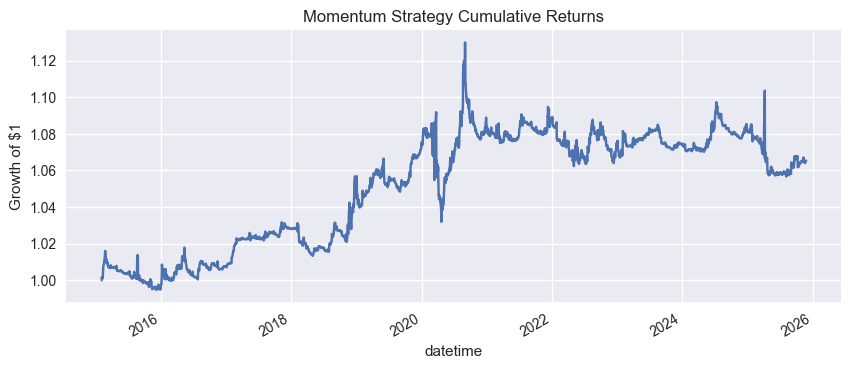

In [14]:
cum_rets = (1 + rets).cumprod()
ax = cum_rets.plot(figsize=(10, 4), title="Momentum Strategy Cumulative Returns")
ax.set_ylabel("Growth of $1")
plt.show()

## RSI (Relative Strength Index)

RSI is a bounded oscillator (0-100) that measures whether recent gains outpace recent losses.
- **RSI > 70**: Potentially overbought (may reverse down)
- **RSI < 30**: Potentially oversold (may reverse up)

We'll use RSI as a contrarian signal: go long when oversold, short when overbought.

In [15]:
rsi = RSI(period=14)
rsi_signal = rsi.compute(data)

# Convert RSI to a trading signal: -1 when overbought, +1 when oversold, 0 otherwise
rsi_position = pd.Series(0.0, index=rsi_signal.index)
rsi_position[rsi_signal > 70] = -1.0  # overbought -> short
rsi_position[rsi_signal < 30] = 1.0   # oversold -> long

print(f"RSI period: {rsi.period}")
rsi_signal.tail()

RSI period: 14


datetime
2025-11-20    51.762799
2025-11-21    59.852250
2025-11-24    65.170242
2025-11-25    66.309334
2025-11-26    66.952271
Name: rsi, dtype: float64

In [16]:
bt_rsi = Backtester(data["close"])
rsi_rets = bt_rsi.run(rsi_position).dropna()

rsi_metrics = {
    "sharpe": sharpe(rsi_rets),
    "sortino": sortino(rsi_rets),
    "max_drawdown": max_drawdown(rsi_rets),
}
rsi_metrics

{'sharpe': np.float64(-0.009337996526479096),
 'sortino': np.float64(-0.015650654461004675),
 'max_drawdown': np.float64(-0.3438033687725191)}

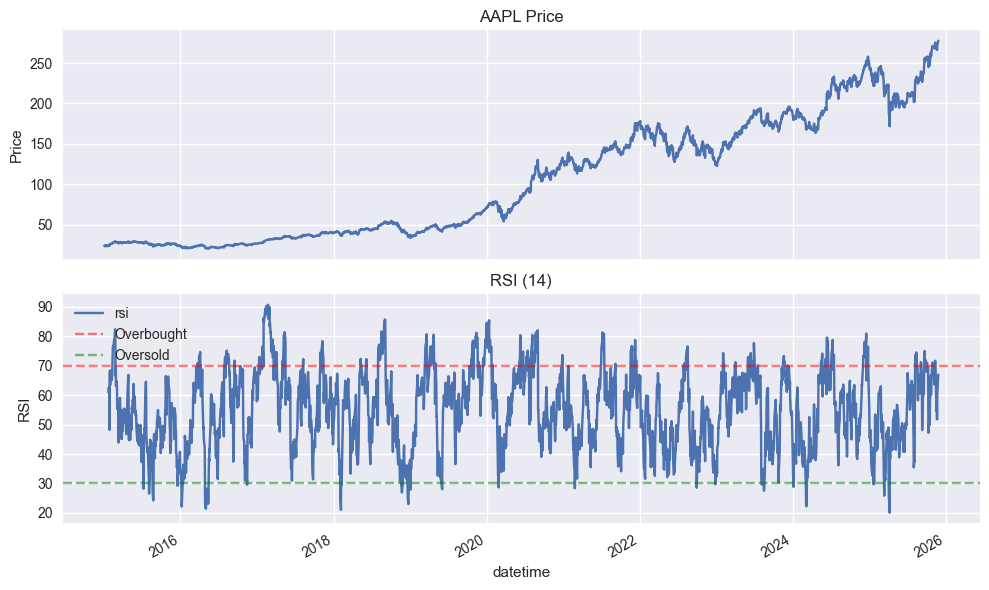

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

data["close"].plot(ax=axes[0], title="AAPL Price")
axes[0].set_ylabel("Price")

rsi_signal.plot(ax=axes[1], title="RSI (14)")
axes[1].axhline(70, color="red", linestyle="--", alpha=0.5, label="Overbought")
axes[1].axhline(30, color="green", linestyle="--", alpha=0.5, label="Oversold")
axes[1].set_ylabel("RSI")
axes[1].legend()

plt.tight_layout()
plt.show()

## MACD (Moving Average Convergence Divergence)

MACD measures momentum by comparing two EMAs of price. It produces three signals:
- **MACD Line**: Fast EMA minus Slow EMA
- **Signal Line**: EMA of the MACD line (smoothed)
- **Histogram**: MACD minus Signal (momentum of momentum)

We'll trade the histogram directly: positive = long, negative = short.

In [18]:
macd = MACD(fast=12, slow=26, signal_period=9)
macd_result = macd.compute(data)

print(f"MACD params: fast={macd.fast}, slow={macd.slow}, signal={macd.signal_period}")
macd_result.to_frame().tail()


MACD params: fast=12, slow=26, signal=9


,macd,signal,histogram
datetime,,,
2025-11-20,3.206074,4.493486,-1.287412
2025-11-21,3.179848,4.230759,-1.050911
2025-11-24,3.476455,4.079898,-0.603443
2025-11-25,3.752981,4.014514,-0.261533
2025-11-26,3.973130,4.006238,-0.033107


In [19]:
bt_macd = Backtester(data["close"])
macd_rets = bt_macd.run(macd_result.histogram).dropna()

macd_metrics = {
    "sharpe": sharpe(macd_rets),
    "sortino": sortino(macd_rets),
    "max_drawdown": max_drawdown(macd_rets),
}
macd_metrics


{'sharpe': np.float64(-0.12030728535868103),
 'sortino': np.float64(-0.15744540149984065),
 'max_drawdown': np.float64(-0.4772419456387959)}

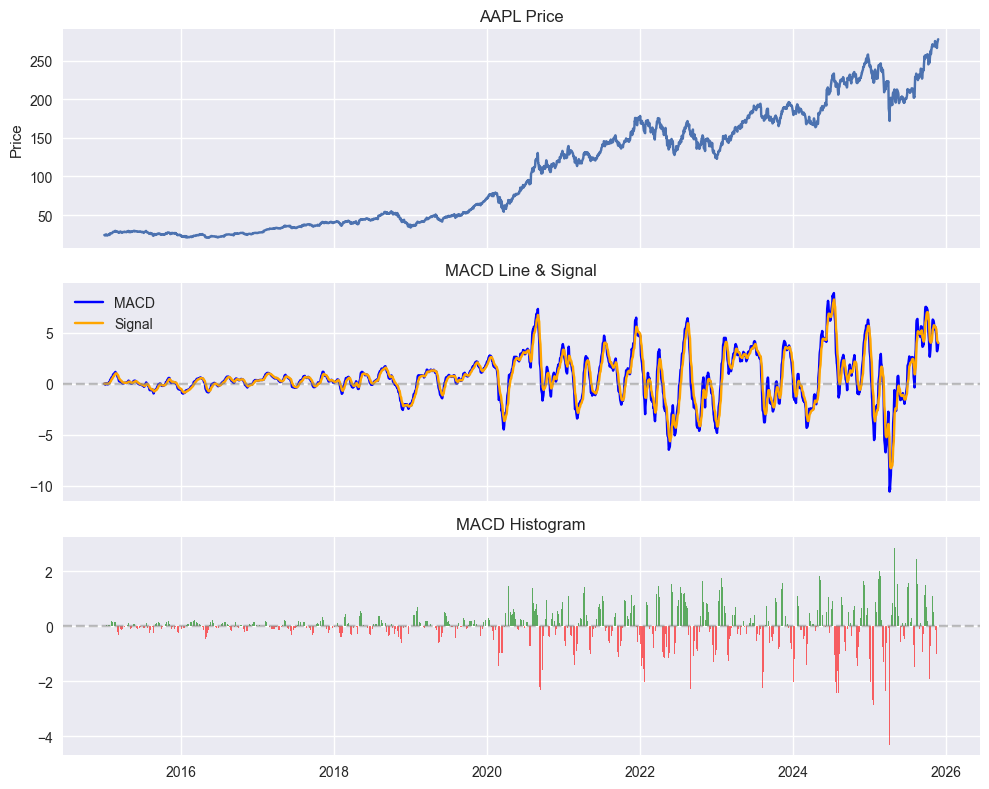

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

data["close"].plot(ax=axes[0], title="AAPL Price")
axes[0].set_ylabel("Price")

macd_result.line.plot(ax=axes[1], label="MACD", color="blue")
macd_result.signal.plot(ax=axes[1], label="Signal", color="orange")
axes[1].axhline(0, color="gray", linestyle="--", alpha=0.5)
axes[1].set_title("MACD Line & Signal")
axes[1].legend()

# Color bars green (positive) or red (negative)
colors = ["green" if v >= 0 else "red" for v in macd_result.histogram]
axes[2].bar(macd_result.histogram.index, macd_result.histogram.values, color=colors, alpha=0.6, width=1)
axes[2].axhline(0, color="gray", linestyle="--", alpha=0.5)
axes[2].set_title("MACD Histogram")

plt.tight_layout()
plt.show()


## Comparison

Let's compare the three strategies side by side.


In [23]:
comparison = pd.DataFrame({
    "Momentum": metrics,
    "RSI": rsi_metrics,
    "MACD": macd_metrics,
}).T

comparison.round(3)


,sharpe,sortino,max_drawdown
Momentum,0.206,0.266,-0.065
RSI,-0.009,-0.016,-0.344
MACD,-0.120,-0.157,-0.477


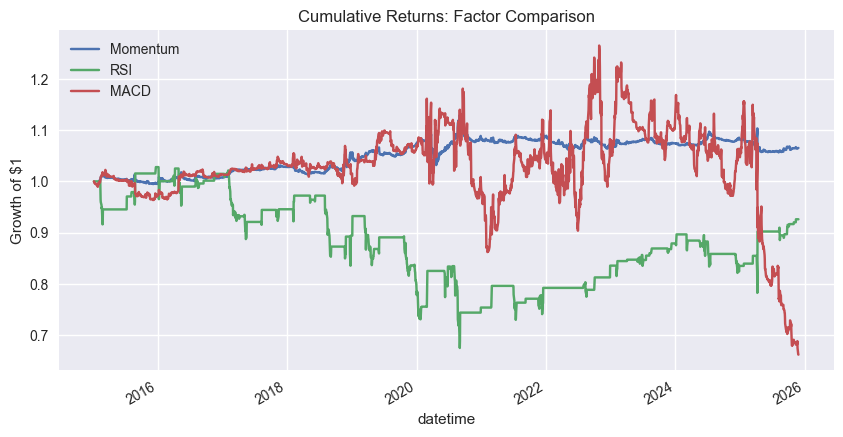

In [24]:
# Cumulative returns comparison
fig, ax = plt.subplots(figsize=(10, 5))

(1 + rets).cumprod().plot(ax=ax, label="Momentum")
(1 + rsi_rets).cumprod().plot(ax=ax, label="RSI")
(1 + macd_rets).cumprod().plot(ax=ax, label="MACD")

ax.set_title("Cumulative Returns: Factor Comparison")
ax.set_ylabel("Growth of $1")
ax.legend()
plt.show()
